Some examples
=============
Here we're going to look at some examples to verify the correctness of the `fem2dsimple` implementation: we will check that some simple analytical solutions of the 2D Poisson equation are matched by the FEM solver.

Example 1
---------
We consider a simple polynomial $u$ as a solution to the Poisson equation:

\begin{equation}
u(x,y) = (x^2 -a x) (y^2 - bx).
\end{equation}

This polynomial has the advantageous property of vanishing at the boundaries of a rectangle given by the set of points $\{ (x,y) : 0 \leq x \leq a, ~ 0  \leq y \leq b \}$.  We will make this rectangle coincide with the rectangular mesh, so that the Dirichlet boundary conditions will be justified.

It is straightforward to find the source term $f$ of the Poisson equation that yields this polynomial as a solution:

\begin{equation}
f(x,y) = -\nabla^2 u(x,y) = -2(y^2 - by) - 2(x^2 - ax).
\end{equation}

Notably, this is a paraboloid centered about $(a/2,b/2)$.

Moving now to the numerical problem, we begin by instantiating the mesh:

In [72]:
import fem2d as fem
import numpy as np

# instantiate mesh
Nx = 16
Ny = 16
Lx = 1.0
Ly = 1.0

mesh = fem.TriangularMesh2D(Nx, Ny, Lx, Ly)
nodes, nx, ny = mesh.nodes, mesh.nx, mesh.ny
x1 = mesh.nodes[:,0].reshape(ny,nx)
y1 = mesh.nodes[:,1].reshape(ny,nx)

We then define two generators for the source term and the analytical (exact) solution, with parameters $a$ and $b$.  We use these to generate $f$ and $u$ choosing $a=L_x$ and $b=L_y$, in order for $u$ to vanish at the boundary of the mesh:

In [73]:
# source term of the Poisson equation (paraboloid)
def f1_gen(a, b, p):
    x = p[...,0]
    y = p[...,1]
    return -2 * ((x**2 - a*x) + (y**2 - b*y))
    
f1 = lambda p : f1_gen(Lx, Ly, p)
f1_mesh = f1(nodes).reshape(ny,nx)

# exact solution of the Poisson equation
def u1_gen(a, b, p):
    x = p[...,0]
    y = p[...,1]
    return (x**2 - a*x) * (y**2 - b*y)
    
u1_ex = lambda p : u1_gen(Lx, Ly, p)
u1_ex_mesh = u1_ex(nodes).reshape(ny,nx)

We can now solve the linear system in the usual way:

In [74]:
from scipy.linalg import solve_banded

# solution of the linear system
A_mat  = fem.stiffn(mesh)
b_vec  = fem.fv_int(mesh, f1)
u1 = solve_banded((nx,nx), A_mat, b_vec).reshape(ny,nx)

And finally we can plot the solutions to compare them:

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotter(X, Y, Z1, Z2, Z3):
    """Plotter function for the source term and the solution of the Poisson equation"""
    fig = plt.figure(figsize=(6.4, 3.0))
    # fig.suptitle("Poisson equation", y= 0.95, fontsize=14)

    # first subplot: f(x, y), source term of the Poisson equation
    ax1 = fig.add_axes((0.0, 0.13, 0.5, 0.8), projection='3d')
    ax1.set_title("source term", y=-0.15)
    ax1.tick_params(labelsize=8, pad=-2)
    ax1.set_xlabel('x', labelpad=-4)
    ax1.set_ylabel('y', labelpad=-4)
    ax1.text2D(0.90, 0.85, "f(x,y)", transform=ax1.transAxes)
    ax1.plot_wireframe(X, Y, Z1, linewidths=0.5)

    # second subplot: u, solution of the linear system
    ax2 = fig.add_axes((0.48, 0.13, 0.5, 0.8), projection='3d')
    ax2.set_title("solution", y=-0.15)
    ax2.tick_params(labelsize=8, pad=-2)
    ax2.tick_params('z', pad=4)
    ax2.set_xlabel('x', labelpad=-4)
    ax2.set_ylabel('y', labelpad=-4)
    ax2.text2D(0.90, 0.85, "u(x,y)", transform=ax2.transAxes)
    ax2.plot_wireframe(X, Y, Z2, linewidths=0.5, colors='C0', label='FEM')
    ax2.scatter(X, Y, Z3, marker='.', c='C1', label='exact')
    ax2.legend(loc=(0, 0.7))

    return fig, ax1, ax2

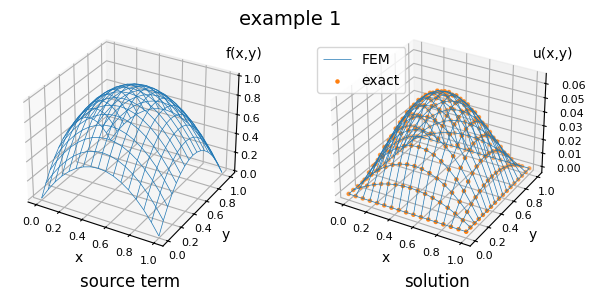

In [76]:
fig = plotter(x1, y1, f1_mesh, u1, u1_ex_mesh)[0]
fig.suptitle("example 1", y= 0.97, fontsize=14)
# plt.savefig("ex1.pdf")
plt.show()

Example 2
=========
We now consider a further example to test `fem2py` with reduced symmetry.  We choose a non-square mesh with rectangular subdivisions:

In [77]:
# instantiate mesh
Nx = 16
Ny = 16
Lx = 1.0
Ly = 2.0

mesh = fem.TriangularMesh2D(Nx, Ny, Lx, Ly)
nodes, nx, ny = mesh.nodes, mesh.nx, mesh.ny
x2 = mesh.nodes[:,0].reshape(ny,nx)
y2 = mesh.nodes[:,1].reshape(ny,nx)

We choose again a solution vanishing at the boundaries of a rectangle, this time with two diversified factors,

\begin{equation}
u(x,y) = (x^3 - a x^2) (y^4 - b^2 y^2),
\end{equation}

which we generate in the usual way:

In [78]:
# exact solution of the Poisson equation
def u2_gen(a, b, p):
    x = p[...,0]
    y = p[...,1]
    return (x**3 - a*x**2) * (y**4 - b**2*y**2)
u2_ex = lambda p : u2_gen(Lx, Ly, p)
u2_ex_mesh = u2_ex(nodes).reshape(ny,nx)

The corresponding source term is

\begin{equation}
f(x,y) = -(6x - 2a)(y^4 - b^2 y^2) -(x^3 - ax^2)(12y^2-2b^2),
\end{equation}

which we also generate:

In [79]:
# source term of the Poisson equation
def f2_gen(a, b, p):
    x = p[...,0]
    y = p[...,1]
    return (-(6*x  - 2*a)    * (y**4    - b**2*y**2)
            -(x**3 - a*x**2) * (12*y**2 - 2*b**2))
f2 = lambda p : f2_gen(Lx, Ly, p)
f2_mesh = f2(nodes).reshape(ny,nx)

Finally we solve the linear system and plot the results:

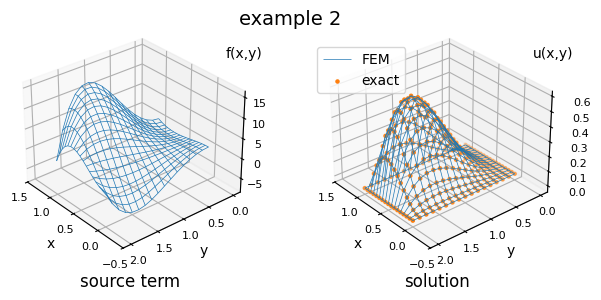

In [80]:
#solution of the linear system
A_mat  = fem.stiffn(mesh)
b_vec  = fem.fv_int(mesh, f2)
u2 = solve_banded((nx,nx), A_mat, b_vec).reshape(ny,nx)

# plot solution
fig, ax1, ax2 = plotter(x2, y2, f2_mesh, u2, u2_ex_mesh)

fig.suptitle("example 2", y= 0.97, fontsize=14)

ax1.set_xlim(-0.5, 1.5)
ax1.view_init(elev=None, azim=140, roll=0)

ax2.set_xlim(-0.5, 1.5)
ax2.view_init(elev=None, azim=140, roll=0)

# plt.savefig("ex2.pdf")
plt.show()